In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit_rigetti import RigettiQCSBackend, RigettiQCSJob, RigettiQCSProvider
from qiskit_rigetti import QuilCircuit

In [3]:
from qiskit.ignis.mitigation import complete_meas_cal, CompleteMeasFitter, tensored_meas_cal, TensoredMeasFitter

In [4]:
import pickle
with open("cmf_tmf.pkl", "rb") as f:
    record = pickle.load(f)

In [4]:
cmf = record["cmf"]
tmf = record["tmf"]

In [5]:
from qiskit_rigetti import RigettiQCSProvider, QuilCircuit

num_qubits = 8
num_clbits = num_qubits

# Create a Bell state circuit
circuit = QuilCircuit(num_qubits, num_clbits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 7)
circuit.cx(1, 2)
circuit.cx(7, 6)
circuit.cx(2, 3)
circuit.cx(6, 5)
circuit.cx(3, 4)
circuit.measure(range(num_qubits), range(num_clbits))

In [6]:
# Get provider and backend
p = RigettiQCSProvider()
backend = p.get_simulator(num_qubits=num_qubits, noisy=True)  # or 
# backend = p.get_backend(name='Aspen-11', qvm=True)
backend

<RigettiQCSBackend('8q-noisy-qvm')>

In [7]:
from qiskit import execute

shots = 1 << 13

# Execute the circuit on the backend
job = execute(circuit, backend, shots=shots)

# Grab results from the job
result = job.result()

# Return memory and counts
counts = result.get_counts(circuit)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [9]:
new_counts = {}
for i in range(1 << num_clbits):
    new_counts[format(i, "0"+str(num_clbits)+"b")] = counts.get(format(i, "0"+str(num_clbits)+"b"), 0)
counts = new_counts

In [11]:
counts_cmf = cmf.filter.apply(counts)
counts_tmf = tmf.filter.apply(counts)

In [13]:
new_counts = {}
for i in range(1 << num_clbits):
    new_counts[format(i, "0"+str(num_clbits)+"b")] = counts_cmf.get(format(i, "0"+str(num_clbits)+"b"), 0)
counts_cmf = new_counts

In [14]:
new_counts = {}
for i in range(1 << num_clbits):
    new_counts[format(i, "0"+str(num_clbits)+"b")] = counts_tmf.get(format(i, "0"+str(num_clbits)+"b"), 0)
counts_tmf = new_counts

In [1]:
import numpy as np
states = np.array(range(1 << num_clbits))
plt.figure(dpi = 300)
plt.bar(states + 0.0, np.array(list(counts.values())) / shots, label="raw")
plt.bar(states + 0.25, np.array(list(counts_cmf.values())) / shots, label="complete")
plt.bar(states + 0.5, np.array(list(counts_tmf.values())) / shots, label="tensored")
plt.xlabel("state")
plt.ylabel("probability")
plt.legend()

NameError: name 'num_clbits' is not defined

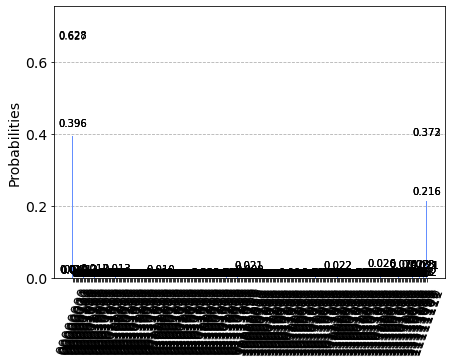

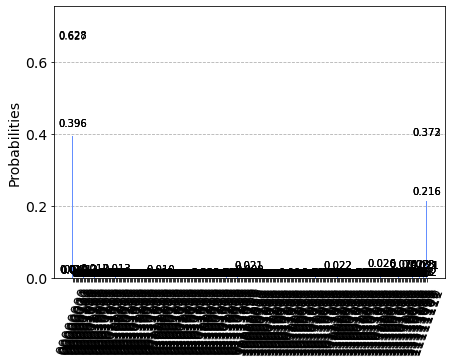

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_cmf, counts_tmf])